## Imports and functions

In [1]:
import datetime
from pathlib import Path
from typing import Dict, List, Union
import warnings
warnings.filterwarnings("ignore")

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})
PARAMS = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(PARAMS)

TIME_FORMAT = '%Y-%m-%d'
INT_TYPE = 'int32'

In [109]:
def load_data(locus_weights_path: Union[str, Path],
              temperature_path: Union[str, Path],
              locus_group_matching_path: Union[str, Path],
              fresh_water_dates_path: Union[str, Path],
              sw_fw_matching_path: Union[str, Path],
              sw_fw_matching_path_with_cnt: Union[str, Path],
              final_locus_weighted_path: Union[str, Path],
              mortality_path: Union[str, Path]) -> Dict[str, pd.DataFrame]:
    
    locus_weights = pd.read_csv(locus_weights_path)
    locus_weights.starttime = pd.to_datetime(locus_weights.starttime, format=TIME_FORMAT)
    locus_weights.endtime = pd.to_datetime(locus_weights.endtime, format=TIME_FORMAT)
    
    temperature = pd.read_csv(temperature_path)
    temperature.event_date = pd.to_datetime(temperature.event_date, format=TIME_FORMAT)
    temperature.locus_group_id=temperature.locus_group_id.astype(INT_TYPE)
    temperature['event_year'] = temperature['event_date'].dt.year

    locus_group_matching = pd.read_csv(locus_group_matching_path)
    locus_group_matching = locus_group_matching.astype(INT_TYPE)

    fresh_water_dates = pd.read_csv(fresh_water_dates_path)
    for d in ['first_movement_date', 'first_feeding_date', 'shipout_date']:
        fresh_water_dates[d] = pd.to_datetime(fresh_water_dates[d], format=TIME_FORMAT)

    sw_fw_matching = pd.read_csv(sw_fw_matching_path)
    sw_fw_matching_with_cnt = pd.read_csv(sw_fw_matching_path_with_cnt)

    sw_fw_cols = ['target_seawater_locus_id',
                  'transport_date',
                  'ponding_date',
                  'pretransfer_fw_locus_population_id',
                  'fish_count_shipped_out',
                  'avg_weight_g_stocked']
    sw_fw_matching = sw_fw_matching[sw_fw_matching.origin_site_type == 'Freshwater'][sw_fw_cols]
    sw_fw_matching.pretransfer_fw_locus_population_id = sw_fw_matching.\
    pretransfer_fw_locus_population_id.astype(INT_TYPE)

    final_locus_weighted = pd.read_csv(final_locus_weighted_path)
    final_locus_weighted.event_date = pd.to_datetime(final_locus_weighted.event_date)

    mortality = pd.read_csv(mortality_path)
    mortality['transfer_date'] = pd.to_datetime(mortality['transfer_date'], format=TIME_FORMAT)
    mortality['transport_year']= mortality['transfer_date'].dt.year


    dataframes = {
        'temperature': temperature,
        'locus_weigts': locus_weights,
        'locus_group_matching': locus_group_matching,
        'final_locus_weighted': final_locus_weighted,
        'fresh_water_dates': fresh_water_dates,
        'sw_fw_matching': sw_fw_matching,
        'sw_fw_matching_with_cnt': sw_fw_matching_with_cnt,
        'mortality': mortality
    }
    
    return dataframes

def weighted_avg(x, weight, factor):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        tmp = x[[weight, factor]].dropna()
        weighted_sum = (tmp[weight] * tmp[factor]).sum()
        count_sum = tmp[weight].sum()
        return weighted_sum / count_sum
    
#this is to not calculate aggregates if at least one value on the main factor column is NaN
def apply_condition(group,main_factor,agg_function):
    if group[main_factor].isnull().any():
        return np.nan
    else:
        return agg_function(group[main_factor])
    
def apply_condition_threshold(group,main_factor,agg_function):
    return agg_function(group[main_factor])

def create_ph_aggregated_factors(ph_df, main_factor, agg_function, function_name, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    agg_df = pd.DataFrame()
    
    agg_df[f'{env_type}-transfer_feeding-{function_name}'] = ph_df[before_transfer & after_first_feeding] \
    .groupby('final_locus_population_id').apply(lambda x: apply_condition(x, main_factor, agg_function))

    agg_df[f'{env_type}-transfer_vaccination-{function_name}'] = ph_df[before_transfer & after_vaccination]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x, main_factor, agg_function))
    
    for week in weeks_before_transfer:
        weeks_before_transfer_date = ph_df['shipout_date'] - pd.to_timedelta(week, unit='W')
        condition = ph_df['event_date'] > weeks_before_transfer_date
        agg_df[f'{env_type}-{week}_weeks_before_transfer-{function_name}'] = ph_df[before_transfer & condition]\
        .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x, main_factor, agg_function))

    mean_df = pd.concat([agg_df.mean(), agg_df.std()], axis=1).rename(columns={0: 'mean', 1: 'std'})
    
    for col in agg_df.columns[:]:
        agg_df[f'{col}-from_mean'] = agg_df[col] - mean_df.loc[col]['mean']
        agg_df[f'{col}-from_mean-abs'] = np.abs(agg_df[col] - mean_df.loc[col]['mean'])

    return agg_df

def create_ph_aggregated_factors_threshold(ph_df, main_factor, lower_bound, upper_bound, agg_function, condition_type, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    agg_df = pd.DataFrame()
    
    higher_max = f'{env_type}-{condition_type}-higher_max-{upper_bound}'
    lower_min = f'{env_type}-{condition_type}-lower_min-{lower_bound}'
    btw_min_max = f'{env_type}-{condition_type}-btw_min_max-{lower_bound}-{upper_bound}'
    
    relative_higher_max = f'{env_type}-{condition_type}-relative_higher_max-{upper_bound}'
    relative_lower_min = f'{env_type}-{condition_type}-relative_lower_min-{lower_bound}'
    relative_out_min_max = f'{env_type}-{condition_type}-relative_out_min_max-{lower_bound}-{upper_bound}'


    agg_df[higher_max] = ph_df[ph_df[main_factor] > upper_bound]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[lower_min] = ph_df[ph_df[main_factor] < lower_bound]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[btw_min_max] = ph_df[ph_df[main_factor].between(lower_bound, upper_bound)]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df['measurements_count'] = ph_df.groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[higher_max] = agg_df[higher_max].fillna(0).astype('int64')
    agg_df[lower_min] = agg_df[lower_min].fillna(0).astype('int64')
    agg_df[btw_min_max] = agg_df[btw_min_max].fillna(0).astype('int64')

    
    agg_df[relative_higher_max] = agg_df[higher_max] / agg_df['measurements_count']
    agg_df[relative_lower_min] =  agg_df[lower_min] /  agg_df['measurements_count']
    agg_df[relative_out_min_max] = 1 - (agg_df[btw_min_max] /agg_df['measurements_count'])
    agg_df.drop(columns='measurements_count', inplace=True)
        
    return agg_df

def create_ph_aggregated_factors_threshold_fixed(ph_df, main_factor, lower_bound, upper_bound, condition_type, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    agg_df = pd.DataFrame()
    
    higher_max = f'{env_type}-{condition_type}-higher_max-{upper_bound}'
    lower_min = f'{env_type}-{condition_type}-lower_min-{lower_bound}'
    btw_min_max = f'{env_type}-{condition_type}-btw_min_max-{lower_bound}-{upper_bound}'
    
    relative_higher_max = f'{env_type}-{condition_type}-relative_higher_max-{upper_bound}'
    relative_lower_min = f'{env_type}-{condition_type}-relative_lower_min-{lower_bound}'
    relative_out_min_max = f'{env_type}-{condition_type}-relative_out_min_max-{lower_bound}-{upper_bound}'

    df_higher_max = ph_df.copy()
    df_higher_max.loc[df_higher_max[main_factor] < upper_bound, main_factor] = np.nan
    agg_df[higher_max] = df_higher_max\
    .groupby(['final_locus_population_id'])[main_factor].count()

    df_lower_min = ph_df.copy()
    df_lower_min.loc[df_lower_min[main_factor] > lower_bound, main_factor] = np.nan
    agg_df[lower_min] = df_lower_min\
    .groupby(['final_locus_population_id'])[main_factor].count()

    df_btw_min_max = ph_df.copy()
    df_btw_min_max.loc[(df_btw_min_max[main_factor] < lower_bound)|(df_btw_min_max[main_factor] > upper_bound), main_factor] = np.nan
    agg_df[btw_min_max] = df_btw_min_max\
    .groupby(['final_locus_population_id'])[main_factor].count()

    agg_df['measurements_count'] = ph_df.groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,np.count_nonzero))
    
    #not sure it works anyhow
#     agg_df[higher_max] = agg_df[higher_max].fillna(0).astype('int64')
#     agg_df[lower_min] = agg_df[lower_min].fillna(0).astype('int64')
#     agg_df[btw_min_max] = agg_df[btw_min_max].fillna(0).astype('int64')
    agg_df.loc[agg_df['measurements_count'].isna(), higher_max] = np.nan
    agg_df.loc[agg_df['measurements_count'].isna(), lower_min] = np.nan
    agg_df.loc[agg_df['measurements_count'].isna(), btw_min_max] = np.nan
    
    agg_df[relative_higher_max] = agg_df[higher_max] / agg_df['measurements_count']
    agg_df[relative_lower_min] =  agg_df[lower_min] /  agg_df['measurements_count']
    agg_df[relative_out_min_max] = 1 - (agg_df[btw_min_max] /agg_df['measurements_count'])
    agg_df.drop(columns='measurements_count', inplace=True)
        
    return agg_df

def create_factors_df(agg_ph_df, factors, key_columns, weight_column, weighted_func):
    """Creates factors df on key_columns level using weight_column to calculate weighted average"""
    factors_dfs = []
    print('Weighting factors')
    for factor in tqdm(factors):
        tmp = agg_ph_df.groupby(key_columns)\
        .apply(weighted_func, weight_column, factor).reset_index().rename(columns={0: factor})
        factors_dfs.append(tmp)

    factor_df = factors_dfs[0]
    for df in factors_dfs[1:]:
        factor_df = factor_df.merge(df, on=key_columns, how='inner')
    return factor_df

def plot_factors(factors_df, path):
    pairplot = sns.pairplot(factors_df[np.append(corr_df.index, 'mortality')], size=(20, 15))
    plt.title('Mortality vs feature pairplot')
    plt.show()

    for ax in pairplot.axes.flatten():
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation=45)
        # rotate y axis labels
        ax.set_ylabel(ax.get_ylabel(), rotation=0)
        # set y labels alignment
        ax.xaxis.get_label().set_horizontalalignment('right')
        ax.yaxis.get_label().set_horizontalalignment('right')
    pairplot.figure.savefig(path / 'mortality_vs_feature_pairplot.jpg')

In [34]:
#usage example plot_slide_chart('ph-8_weeks_before_transfer-relative_lower_min-6.9','P4',.01,.95,.05,'perc')
def plot_slide_chart(factor,finding_name,low_q,high_q,step,format_chart):
    sns.set_style("whitegrid")

    bins_tuple=tuple(i*step for i in range(
        int(factors_df[factor].quantile(low_q)/step), int(factors_df[factor].quantile(high_q)/step)+1)
    )
    arr_for_chart = factors_df_with_mean_ph.copy()
    arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
    arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

    x_axis_factor = factor+'_binned'
    y_axis_factor = 'mortality'

    plt.figure()

    f, axs = plt.subplots(1,1, figsize=(16,8), sharex=True)
    box_plot=sns.boxplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor,width=.2)

    medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
    medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()
    
#     vertical_offset = arr_for_chart[y_axis_factor].median() * 0.00 # offset from median for display
#     for xtick in box_plot.get_xticks():
#         box_plot.text(xtick + 0.15,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
#                       horizontalalignment='center',size='xx-large',color='black',weight='semibold')


    xtick_labels = [tick.get_text() for tick in axs.get_xticklabels()]
    counts = arr_for_chart[x_axis_factor].value_counts().sort_index()

    updated_labels=[]
    for i,v in enumerate(xtick_labels):
        bin_range1 = v.split(", ")[0][1:]
        bin_range2 = v.split(", ")[1][:-1]
        if format_chart=='perc':
            updated_label = "{:.0%}".format(float(bin_range1))+' to ' + "{:.0%}".format(float(bin_range2))
        elif format_chart=='one_dec':
            updated_label = "{:.1}".format(float(bin_range1))+' to ' + "{:.1}".format(float(bin_range2))
        elif format_chart=='two_dec':
            updated_label = "{:.2}".format(float(bin_range1))+' to ' + "{:.2}".format(float(bin_range2))

    #     updated_labels.append(f"{updated_label} ({counts.iloc[i]})")
        updated_labels.append(f"{updated_label} ")
    axs.set_xticklabels(updated_labels)

    # Add black dots with average values
    for i, xtick in enumerate(box_plot.get_xticks()):
        bin_data = arr_for_chart[arr_for_chart[x_axis_factor] == xtick_labels[i]]
        avg_value = medians.iloc[i]
        axs.plot(xtick, avg_value, marker='o', markersize=8, color='black')
    # Create table
    result_array = np.vstack((medians, medians2, counts.values.astype(int)))

    # Adjust the layout
    # plt.subplots_adjust(left=0.2, bottom=0.1)

    # plt.show()
    # plt.savefig(f'Visualisation\Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')
    # plt.savefig(f'Visualisation\Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average2.jpg')
    # plt.savefig(f'Visualisation\Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average3.jpg')
    plt.savefig(f'Visualisation\slides\{finding_name}_Boxplot_{y_axis_factor}_vs_{factor}_slide.png')
    
    return(result_array)

## Data processing

In [3]:
vaccines = pd.read_csv('data/vaccines_with_final_locus_population_id.csv')
vaccines['VAC_EVENT_DATE'] = pd.to_datetime(vaccines['VAC_EVENT_DATE'] , format=TIME_FORMAT)
vaccines_agg = pd.DataFrame(vaccines.groupby('FINAL_LOCUS_POPULATION_ID')['VAC_EVENT_DATE'].mean())

tgc = pd.read_csv('data/transfers_until2023Feb28_with_sw_growth_targets.csv')

In [4]:
# ph_data = pd.read_csv('data/ph_final_lg_grouped.csv')
ph_data = pd.read_csv('data/ph_data_smoothed.csv')

vaccines = pd.read_csv('data/vaccines_with_final_locus_population_id.csv')
vaccines['VAC_EVENT_DATE'] = pd.to_datetime(vaccines['VAC_EVENT_DATE'] , format=TIME_FORMAT)
vaccines_agg = pd.DataFrame(vaccines.groupby('FINAL_LOCUS_POPULATION_ID')['VAC_EVENT_DATE'].mean())

<AxesSubplot:>

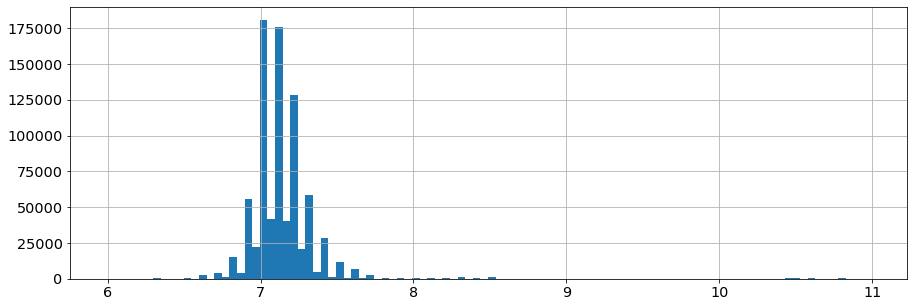

In [15]:
# ph_data[ph_data.ph_value.between(6,11)
#        ].ph_value.hist(bins=100)

<AxesSubplot:>

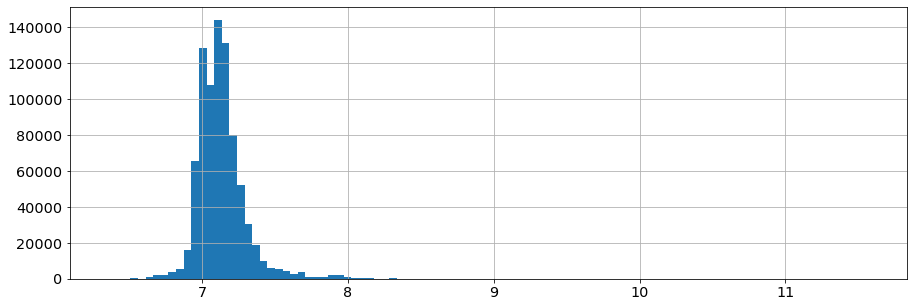

In [6]:
ph_data.ph.hist(bins=100)

In [7]:
dataframes = load_data(locus_weights_path='data/evt_movement_ratio_with_dates.csv',
                       temperature_path='data/temperature_for_CAM.csv',
                       locus_group_matching_path='data/locus_locus_group_matching.csv',
                       fresh_water_dates_path='data/FW_cycle_dates.csv',
                       sw_fw_matching_path='data/seawater_freshwater_matching.csv',
                       sw_fw_matching_path_with_cnt='data/sw_locus_fw_locus_population_with_counts.csv',
                       final_locus_weighted_path='data/lw_alldates_final_locus.csv',
                       mortality_path='data/smolt_dataset_transfers_until2023Feb28_narrow.csv')

temperature = dataframes['temperature']
locus_weights = dataframes['locus_weigts']
locus_group_matching = dataframes['locus_group_matching']
final_locus_weighted = dataframes['final_locus_weighted']
fresh_water_dates = dataframes['fresh_water_dates']
sw_fw_matching = dataframes['sw_fw_matching']
mortality = dataframes['mortality']
sw_fw_matching_with_cnt = dataframes['sw_fw_matching_with_cnt']

In [8]:
fresh_water_dates.rename(columns={'pretransfer_fw_locus_population_id': 'final_locus_population_id'}, inplace=True)

ph_data_with_dates = ph_data.merge(
    fresh_water_dates,
    how='inner'
)

ph_data_with_dates = ph_data_with_dates.merge(
    vaccines_agg,
    left_on='final_locus_population_id',
    right_on='FINAL_LOCUS_POPULATION_ID',
    how='inner'
)

In [9]:
sw_fw_matching.transport_date = pd.to_datetime(sw_fw_matching.transport_date, format=TIME_FORMAT)
ph_data_with_dates['shipout_year'] = ph_data_with_dates['shipout_date'].dt.year

sw_fw_matching_with_cnt.transfer_date = pd.to_datetime(sw_fw_matching_with_cnt['transfer_date'], format=TIME_FORMAT)
sw_fw_matching_with_cnt['transfer_year'] = sw_fw_matching_with_cnt['transfer_date'].dt.year

In [10]:
mortality_cols = ['locus_id',
                  'fish_group_id',
                  'transfer_year',
                  'transfer_month',
                  'transfer_month_year',
                  'transfer_season',
                  'transfer_season2',
                  'total_count',
                  'total_mortality_perc_90']

sw_cols = ['to_locus_id',
           'to_fish_group_id',
           'transfer_date',
           'from_locus_population_id',
           'from_count_stocking',
           'transfer_year']

mortality_final_locus = mortality[mortality_cols].merge(
    sw_fw_matching_with_cnt[sw_cols],
    left_on=['fish_group_id', 'locus_id','transfer_year'],
    right_on=['to_fish_group_id', 'to_locus_id','transfer_year'],
    how='left'
)

mortality_final_locus['from_locus_population_id'] = mortality_final_locus['from_locus_population_id'].fillna(0).astype('int32')

In [11]:
before_transfer = ph_data_with_dates['event_date'] < ph_data_with_dates['shipout_date']
after_vaccination = ph_data_with_dates['event_date'] > ph_data_with_dates['VAC_EVENT_DATE']
before_vaccination = ph_data_with_dates['event_date'] < ph_data_with_dates['VAC_EVENT_DATE']
after_first_feeding = ph_data_with_dates['event_date'] > ph_data_with_dates['first_feeding_date']
weeks_before_transfer = [2, 4, 6, 8]
#name of column with values of the factor
main_factor = 'ph'
key_columns = ['locus_id','fish_group_id','transfer_year']

## Factors aggregation

In [12]:
agg_functions = {
    'mean': np.mean,
    'min': np.min,
    'max': np.max,
    'std': np.std,
    'cv': lambda x: np.std(x) / np.mean(x),  # coefficient of variation
    'threshold': np.count_nonzero,
}

In [13]:
six_weeks_condition = ph_data_with_dates['event_date'] > (ph_data_with_dates['shipout_date'] - pd.to_timedelta(6, unit='W'))
eight_weeks_condition = ph_data_with_dates['event_date'] > (ph_data_with_dates['shipout_date'] - pd.to_timedelta(8, unit='W'))
threshold_conditions = {
    '6_weeks_before_transfer': before_transfer & six_weeks_condition,
    '8_weeks_before_transfer': before_transfer & eight_weeks_condition,
    'vaccination_transfer': before_transfer & after_vaccination,
    'first_feeding_transfer': before_transfer & after_first_feeding,
    'first_feeding_vaccination': after_first_feeding & before_vaccination,
}

In [14]:
max_threshold = 7.3
min_threshold = 6.9
print(f'Min ph threshold: {min_threshold}, max ph threshold: {max_threshold}')

Min ph threshold: 6.9, max ph threshold: 7.3


In [103]:
# tmp=ph_data_with_dates[before_transfer & eight_weeks_condition]
# tmp.loc[tmp['ph'] < 7.3, 'ph'] = np.nan
# tmp.groupby(['final_locus_population_id'])[main_factor].count()

final_locus_population_id
36783130     0
36783339     0
36783413     0
36783453     0
36783456     0
            ..
194650512    0
194650513    0
194650515    0
194650516    0
194650523    0
Name: ph, Length: 2959, dtype: int64

In [69]:
#it's wrong
# ph_data_with_dates[before_transfer & eight_weeks_condition][ph_data_with_dates['ph'] > 7.3]\
#     .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,np.count_nonzero))

,final_locus_population_id,event_date,ph,pretransfer_fw_locus_id,first_movement_date,first_feeding_date,shipout_date,VAC_EVENT_DATE,shipout_year
409,36783130,2018-02-17,NaN,3048195,2017-01-04,2017-08-12,2018-04-13,2018-02-11 12:00:00,2018
410,36783130,2018-02-18,NaN,3048195,2017-01-04,2017-08-12,2018-04-13,2018-02-11 12:00:00,2018
411,36783130,2018-02-19,NaN,3048195,2017-01-04,2017-08-12,2018-04-13,2018-02-11 12:00:00,2018
412,36783130,2018-02-20,NaN,3048195,2017-01-04,2017-08-12,2018-04-13,2018-02-11 12:00:00,2018
413,36783130,2018-02-21,NaN,3048195,2017-01-04,2017-08-12,2018-04-13,2018-02-11 12:00:00,2018
...,...,...,...,...,...,...,...,...,...
1391378,194650523,2023-02-24,6.992857,3046268,2021-11-04,2022-04-12,2023-03-01,2022-11-08 07:12:00,2023
1391379,194650523,2023-02-25,7.008333,3046268,2021-11-04,2022-04-12,2023-03-01,2022-11-08 07:12:00,2023
1391380,194650523,2023-02-26,7.025000,3046268,2021-11-04,2022-04-12,2023-03-01,2022-11-08 07:12:00,2023
1391381,194650523,2023-02-27,7.042857,3046268,2021-11-04,2022-04-12,2023-03-01,2022-11-08 07:12:00,2023


In [110]:
agg_dfs = []

for name, func in tqdm(agg_functions.items()):
    if name != 'threshold':
        agg_df = create_ph_aggregated_factors(ph_data_with_dates,
                                              main_factor,
                                              agg_function=func,
                                              function_name=name,
                                              env_type='ph')
        agg_dfs.append(agg_df)
    else:
        for condition_type, condition in threshold_conditions.items():
            agg_df = create_ph_aggregated_factors_threshold_fixed(
                ph_data_with_dates[condition],
                main_factor,
                min_threshold,
                max_threshold,
#                 agg_function=func,
                condition_type=condition_type,
                env_type='ph'
            )
            agg_dfs.append(agg_df)
    
agg_df = pd.concat(agg_dfs)

agg_df = agg_df.merge(
    mortality_final_locus[['from_locus_population_id', 'locus_id','fish_group_id', 'transfer_year', 'from_count_stocking']],
    left_on=['final_locus_population_id',],
    right_on=['from_locus_population_id',],
    how='right')

factors = agg_df.columns.difference(
    ['from_locus_population_id', 'locus_id', 'fish_group_id', 'transfer_year', 'from_count_stocking']
)

factors_df = create_factors_df(agg_df,
                               factors,
                               key_columns, 
                               weight_column='from_count_stocking',
                               weighted_func=weighted_avg)
factors_df = factors_df.merge(
    pd.DataFrame(mortality_final_locus.groupby(key_columns)['total_mortality_perc_90'].mean()),
    on=key_columns,
    how='inner'
)

factors_df = factors_df.merge(
    pd.DataFrame(tgc.groupby(key_columns)['TGC_SW'].mean()),
    on=key_columns,
    how='inner'
)

factors_df.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)

factors_df.to_csv('data/factors_ph_smoothed.csv', index=False)

  0%|                                                                            | 0/120 [00:00<?, ?it/s]

Weighting factors


100%|██████████████████████████████████████████████████████████████████| 120/120 [02:57<00:00,  1.48s/it]


In [96]:
# factors_df_old=factors_df.copy()

In [53]:
sf_ph=pd.read_csv('data/significant_factors_ph.csv').columns[3:8]

In [127]:
factors_df[key_columns+list(sf_ph)][factors_df.locus_id==3046627]#.to_csv('data/significant_factors_ph_smoothed.csv',index=False)#.isna().sum()

,locus_id,fish_group_id,transfer_year,ph-8_weeks_before_transfer-std,ph-8_weeks_before_transfer-max,ph-8_weeks_before_transfer-relative_higher_max-7.3,ph-8_weeks_before_transfer-relative_lower_min-6.9,ph-transfer_vaccination-std
139,3046627,61,2019,NaN,NaN,NaN,NaN,NaN
140,3046627,5737,2021,0.073332,7.214286,0.0,0.0,0.072174


In [120]:
sf_ph_GV=pd.read_csv('modeling/data/factors_ph_unsmoothed_UPD.csv')

In [126]:
sf_ph_GV[key_columns+list(sf_ph)][sf_ph_GV['ph-8_weeks_before_transfer-max']>10]

,locus_id,fish_group_id,transfer_year,ph-8_weeks_before_transfer-std,ph-8_weeks_before_transfer-max,ph-8_weeks_before_transfer-relative_higher_max-7.3,ph-8_weeks_before_transfer-relative_lower_min-6.9,ph-transfer_vaccination-std
25,3046627,5737,2021,0.752068,12.700000,0.054545,0.000000,0.728707
33,3046709,3918,2020,3.450264,32.924445,0.026248,0.000000,3.048354
54,3047195,3911,2020,3.075205,30.101436,0.031219,0.000000,2.544534
74,3047580,5740,2021,0.516229,10.704187,0.054545,0.000000,0.496015
89,3047910,4166,2021,0.758389,12.700000,0.018182,0.000000,0.746650
106,3048336,3918,2020,4.275147,39.099998,0.036364,0.000000,3.852127
113,3048417,3918,2020,3.604973,34.067911,0.033487,0.000000,3.271950
116,3048500,4166,2021,0.762029,12.700000,0.018182,0.018182,0.762029
120,3048554,3912,2020,1.079162,15.151786,0.018182,0.000000,0.941185
123,3048617,4166,2021,0.758389,12.700000,0.018182,0.000000,0.752200


In [18]:
corr_df = pd.DataFrame(factors_df[factors].apply(lambda x: x.corr(factors_df['mortality'])), columns=['corr'])

highest_corr = corr_df.nlargest(20, columns='corr')
lowest_corr = corr_df.nsmallest(20, columns='corr')
print(highest_corr)
print(lowest_corr)

                                                       corr
ph-8_weeks_before_transfer-btw_min_max-6.9-7.3     0.305788
ph-vaccination_transfer-relative_higher_max-7.3    0.270070
ph-transfer_feeding-mean-from_mean                 0.243185
ph-transfer_feeding-mean                           0.243185
ph-first_feeding_vaccination-btw_min_max-6.9-7.3   0.156206
ph-transfer_feeding-min-from_mean                  0.153492
ph-transfer_feeding-min                            0.153492
ph-6_weeks_before_transfer-btw_min_max-6.9-7.3     0.100515
ph-8_weeks_before_transfer-min-from_mean-abs       0.062380
ph-first_feeding_transfer-relative_higher_max-7.3  0.057927
ph-transfer_vaccination-min-from_mean              0.051282
ph-transfer_vaccination-min                        0.051282
ph-6_weeks_before_transfer-min-from_mean-abs       0.042873
ph-2_weeks_before_transfer-min                     0.042599
ph-2_weeks_before_transfer-min-from_mean           0.042599
ph-first_feeding_transfer-higher_max-7.3

In [20]:
corr_df = pd.DataFrame(factors_df[factors].apply(lambda x: x.corr(factors_df['TGC_SW'])), columns=['corr'])

highest_corr = corr_df.nlargest(20, columns='corr')
lowest_corr = corr_df.nsmallest(20, columns='corr')
print(highest_corr)
print(lowest_corr)

                                                    corr
ph-transfer_feeding-min-from_mean-abs           0.346418
ph-6_weeks_before_transfer-btw_min_max-6.9-7.3  0.282238
ph-8_weeks_before_transfer-btw_min_max-6.9-7.3  0.269536
ph-4_weeks_before_transfer-cv                   0.247624
ph-4_weeks_before_transfer-cv-from_mean         0.247624
ph-4_weeks_before_transfer-std-from_mean        0.246367
ph-4_weeks_before_transfer-std                  0.246367
ph-2_weeks_before_transfer-cv                   0.236498
ph-2_weeks_before_transfer-cv-from_mean         0.236498
ph-2_weeks_before_transfer-std                  0.234810
ph-2_weeks_before_transfer-std-from_mean        0.234810
ph-2_weeks_before_transfer-max                  0.219029
ph-2_weeks_before_transfer-max-from_mean        0.219029
ph-4_weeks_before_transfer-max                  0.199855
ph-4_weeks_before_transfer-max-from_mean        0.199855
ph-2_weeks_before_transfer-std-from_mean-abs    0.184115
ph-2_weeks_before_transfer-cv-f

## Checking Denis's Findings

### Finding 1: Increased std -> Increased mortality

In [23]:
tmp = ph_data_with_dates.merge(mortality_final_locus,
                               left_on='final_locus_population_id',
                               right_on='from_locus_population_id')


factors_df_with_mean_ph = factors_df.merge(
    pd.DataFrame(tmp[key_columns+[main_factor]].groupby(key_columns)[main_factor].mean()),
    on=key_columns,
    how='left'
)

In [26]:
factors_df['ph-8_weeks_before_transfer-std']

0            NaN
1            NaN
2       0.030618
3       0.027154
4            NaN
          ...   
1257    0.073024
1258    0.058314
1259    0.058314
1260    0.058026
1261    0.092339
Name: ph-8_weeks_before_transfer-std, Length: 1262, dtype: float64

<Figure size 1080x360 with 0 Axes>

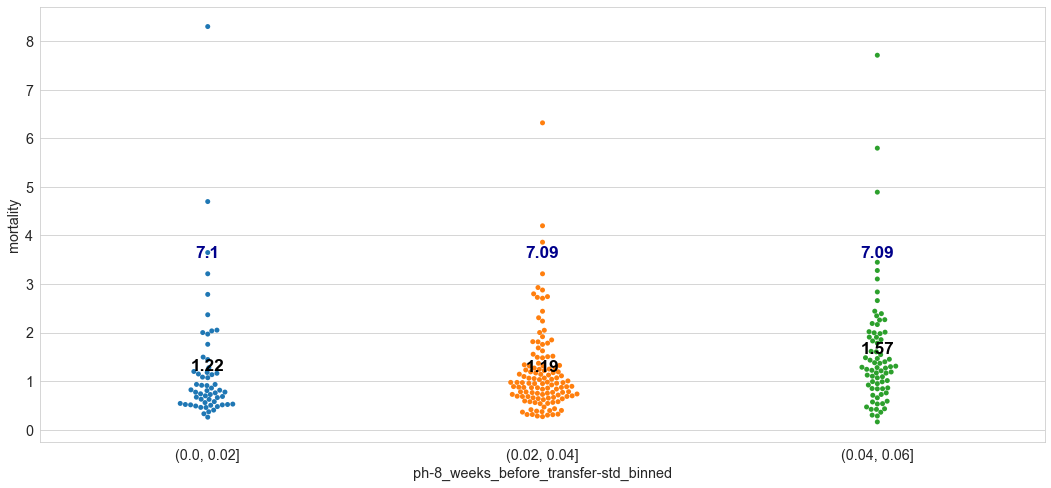

<Figure size 1080x360 with 0 Axes>

In [37]:
sns.set_style("whitegrid")

step = 0.02

factor = 'ph-8_weeks_before_transfer-std'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.8)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'mortality'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
plt.savefig(f'Visualisation/Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average_smoothed.jpg')

<Figure size 1080x360 with 0 Axes>

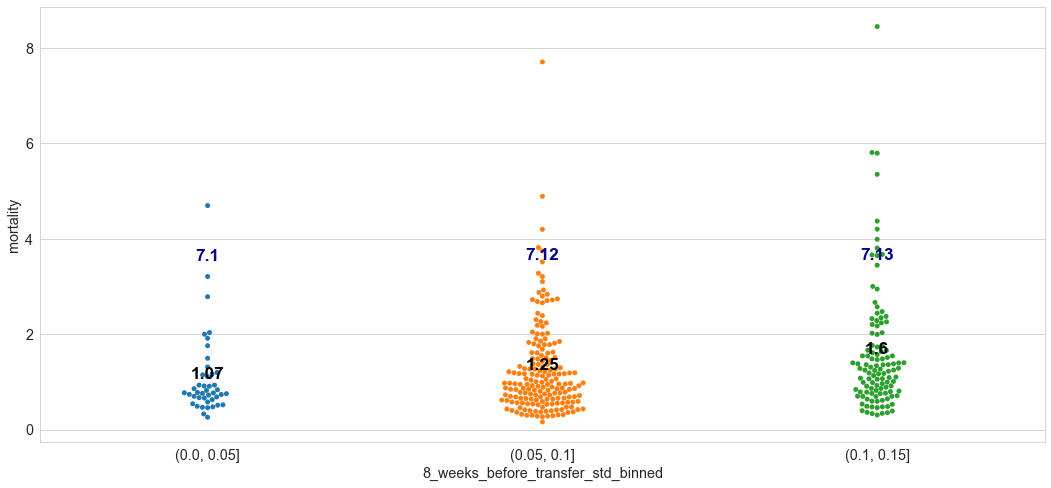

<Figure size 1080x360 with 0 Axes>

In [77]:
sns.set_style("whitegrid")

step = 0.05

factor = '8_weeks_before_transfer_std'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.8)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'mortality'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
# plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

array([[  1.22276851,   1.18698413,   1.5665766 ],
       [  7.09952991,   7.0926462 ,   7.09395615],
       [ 57.        , 121.        ,  74.        ]])

<Figure size 1080x360 with 0 Axes>

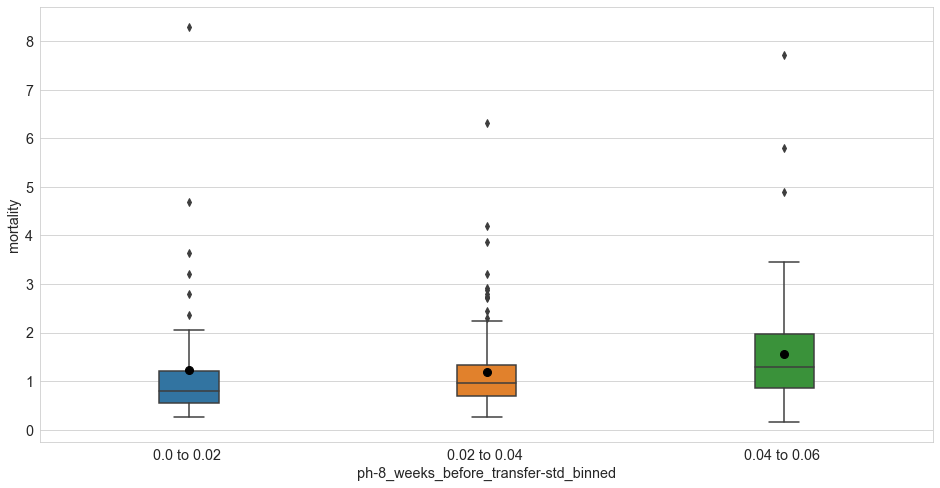

In [38]:
plot_slide_chart('ph-8_weeks_before_transfer-std','P1',.01,.8,.02,'two_dec')

array([[  1.06952699,   1.24855624,   1.600201  ],
       [  7.09822844,   7.12253808,   7.12672611],
       [ 43.        , 181.        , 115.        ]])

<Figure size 1080x360 with 0 Axes>

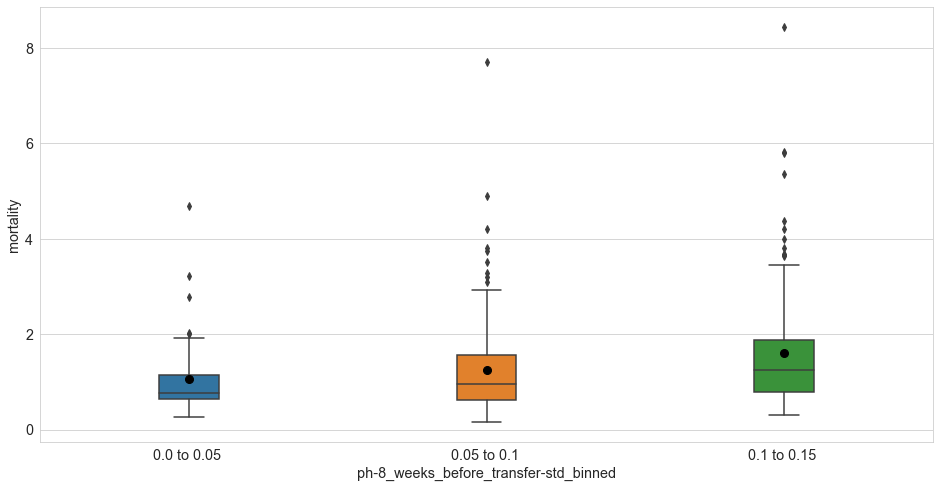

In [362]:
plot_slide_chart('ph-8_weeks_before_transfer-std','P1',.01,.8,.05,'two_dec')

### Finding 2: increased max ph -> mortality

<Figure size 1080x360 with 0 Axes>

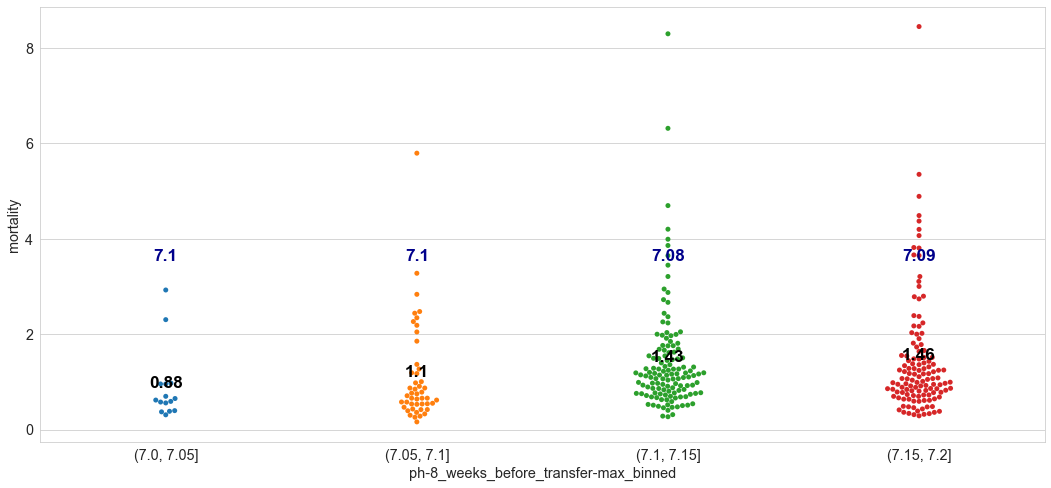

In [42]:
sns.set_style("whitegrid")

step = 0.05

factor = 'ph-8_weeks_before_transfer-max'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.80)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'mortality'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
# plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

<Figure size 1080x360 with 0 Axes>

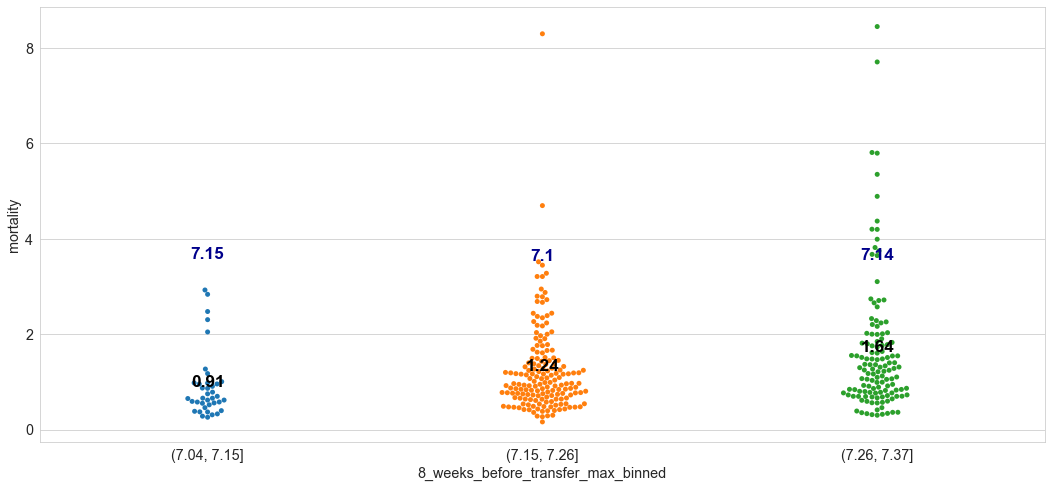

<Figure size 1080x360 with 0 Axes>

In [64]:
sns.set_style("whitegrid")

step = 0.11

factor = '8_weeks_before_transfer_max'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.80)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'mortality'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

### Finding 3:  Relative higher max vs mortality

In [34]:
highest_corr.iloc[0].name

'ph-first_feeding_transfer-relative_higher_max-7.3'

array([[  1.03153889,   1.27370845],
       [  7.17722598,   7.19418234],
       [126.        ,  50.        ]])

<Figure size 1080x360 with 0 Axes>

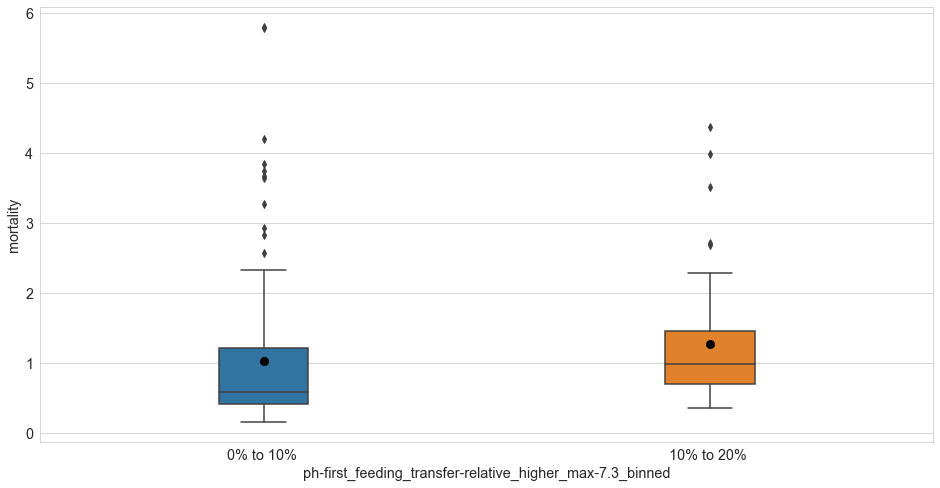

In [350]:
# plot_slide_chart('ph-first_feeding_transfer-relative_higher_max-7.3','P3')

<Figure size 1080x360 with 0 Axes>

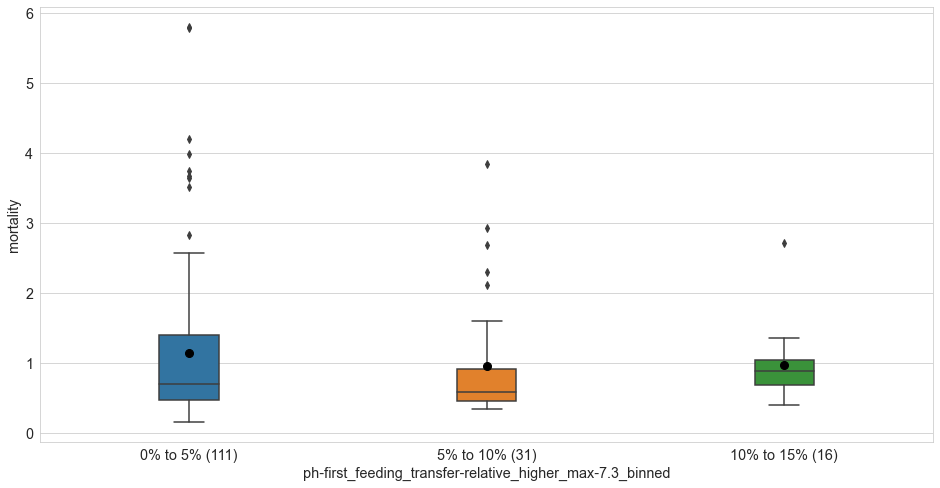

In [106]:
sns.set_style("whitegrid")

step = 0.05

# factor = 'relative_higher_max_first_feeding_transfer'
factor = 'ph-first_feeding_transfer-relative_higher_max-7.3'
# factor = 'ph-first_feeding_vaccination-relative_higher_max-7.3'
# factor = 'ph-first_feeding_vaccination-relative_higher_max-7.3'
# factor = 'ph-vaccination_transfer-relative_higher_max-7.3'
# factor = 'ph-8_weeks_before_transfer-relative_higher_max-7.3'


bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.99)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'mortality'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(16,8), sharex=True)
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 14), gridspec_kw={'height_ratios': [2.5, 1], 'hspace': 0})

# box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
box_plot=sns.boxplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor,width=.2)
# box_plot=sns.boxplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor, ax=ax1)


medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


# vertical_offset = arr_for_chart[y_axis_factor].median() * 0.00 # offset from median for display
# for xtick in box_plot.get_xticks():
#     box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
#                   horizontalalignment='center',size='xx-large',color='black',weight='semibold')

# vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
# for xtick in box_plot.get_xticks():
#     box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
#                   horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
    
# Add counts to x-axis labels
# ax = plt.gca()
xtick_labels = [tick.get_text() for tick in axs.get_xticklabels()]
counts = arr_for_chart[x_axis_factor].value_counts().sort_index()

updated_labels=[]
for i,v in enumerate(xtick_labels):
    bin_range1 = v.split(", ")[0][1:]
    bin_range2 = v.split(", ")[1][:-1]
    updated_label = "{:.0%}".format(float(bin_range1))+' to ' + "{:.0%}".format(float(bin_range2))
    updated_labels.append(f"{updated_label} ({counts.iloc[i]})")
#     updated_labels.append(f"{updated_label} ")
axs.set_xticklabels(updated_labels)

# Add black dots with average values
for i, xtick in enumerate(box_plot.get_xticks()):
    bin_data = arr_for_chart[arr_for_chart[x_axis_factor] == xtick_labels[i]]
    avg_value = medians.iloc[i]
    axs.plot(xtick, avg_value, marker='o', markersize=8, color='black')
    

# Adjust the layout
# plt.subplots_adjust(left=0.2, bottom=0.1)

# plt.show()
# plt.savefig(f'Visualisation\Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')
# plt.savefig(f'Visualisation\Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average2.jpg')
# plt.savefig(f'Visualisation\Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average3.jpg')
# plt.savefig(f'Visualisation\Boxplot_{y_axis_factor}_vs_{factor}_slide.png')

<Figure size 1080x360 with 0 Axes>

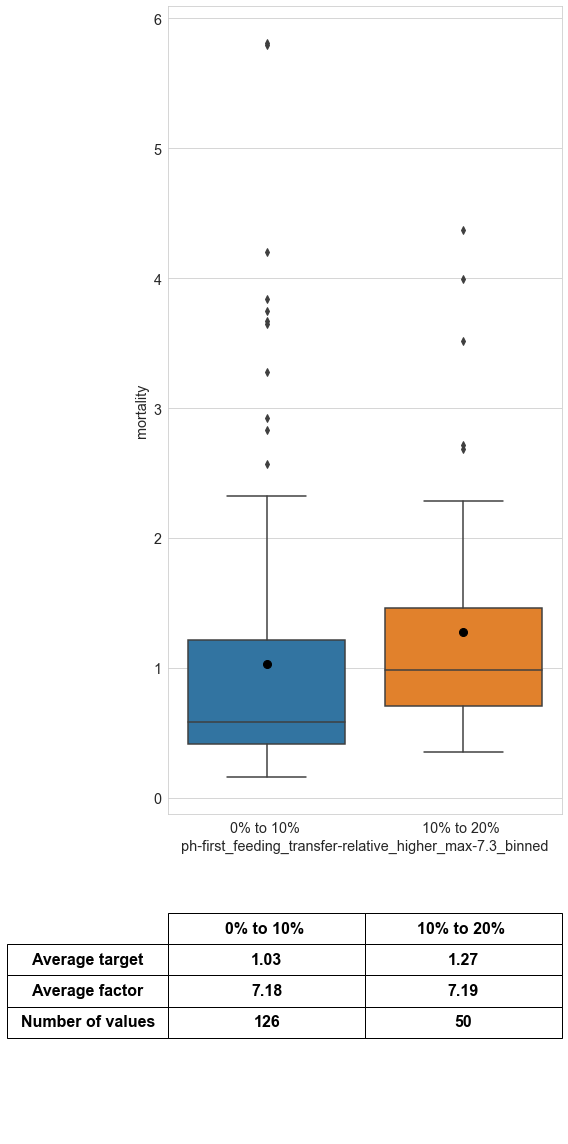

In [338]:
# # with table
# sns.set_style("whitegrid")
# step = 0.1
# factor = 'ph-first_feeding_transfer-relative_higher_max-7.3'

# bins_tuple = tuple(i * step for i in range(int(factors_df[factor].quantile(.01) / step), int(factors_df[factor].quantile(.99) / step) + 1))
# arr_for_chart = factors_df_with_mean_ph.copy()
# arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
# arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

# x_axis_factor = factor+'_binned'
# y_axis_factor = 'mortality'

# plt.figure()
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 16), gridspec_kw={'height_ratios': [2.5, 1], 'hspace': 0})

# # Create boxplot
# box_plot = sns.boxplot(data=arr_for_chart, x=x_axis_factor, y=y_axis_factor, ax=ax1)

# # Compute medians
# medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
# medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()

# # Update x-axis labels
# xtick_labels = [tick.get_text() for tick in ax1.get_xticklabels()]
# counts = arr_for_chart[x_axis_factor].value_counts().sort_index()
# updated_labels = [f"{'{:.0%}'.format(float(v.split(', ')[0][1:]))} to {'{:.0%}'.format(float(v.split(', ')[1][:-1]))} " for v in xtick_labels]
# ax1.set_xticklabels(updated_labels)

# # Add black dots for average values
# for i, xtick in enumerate(box_plot.get_xticks()):
#     avg_value = medians.iloc[i]
#     ax1.plot(xtick, avg_value, marker='o', markersize=8, color='black')

# # Create table
# result_array = np.vstack((medians, medians2, counts.values.astype(int)))
# row_labels = ['Average target', 'Average factor', 'Number of values']
# table = ax2.table(cellText=result_array, rowLabels=row_labels, colLabels=updated_labels, loc='center')
# table.auto_set_font_size(False)
# table.set_fontsize(16)
# table.scale(1, 2)

# # Format table cells
# for cell in table._cells:
#     cell_text = table._cells[cell].get_text()
#     row, col = cell
#     if 2 >= row >= 1 and col >= 0:
#         rounded_value = round(float(cell_text.get_text()), 2)
#         cell_text.set_text(str(rounded_value))
#     elif row == 3 and col >= 0:
#         rounded_value = round(float(cell_text.get_text()))
#         cell_text.set_text(str(rounded_value))
#     cell_text.set_ha('center')
#     cell_text.set_va('center')

# # Style the table
# table_cells = table.get_celld()
# for key in table_cells:
#     cell = table_cells[key]
#     cell.set_text_props(weight='bold', color='black', size='medium')
#     cell.set_edgecolor('black')
#     cell_text = cell.get_text()
#     cell_text.set_fontsize(16)

# # Hide the axis for the second subplot
# ax2.axis('off')

# # Adjust the layout
# plt.tight_layout()

# # Save the figure
# # plt.savefig(f'Visualisation\Boxplot_{y_axis_factor}_vs_{factor}_with_the_table.png')

### FInding 4: Mortality vs relative_lower_min

In [ ]:
sns.set_style("whitegrid")

step = 0.1

factor = 'relative_lower_min_8_weeks_before_transfer'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.986)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'mortality'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
# plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

<Figure size 1080x360 with 0 Axes>

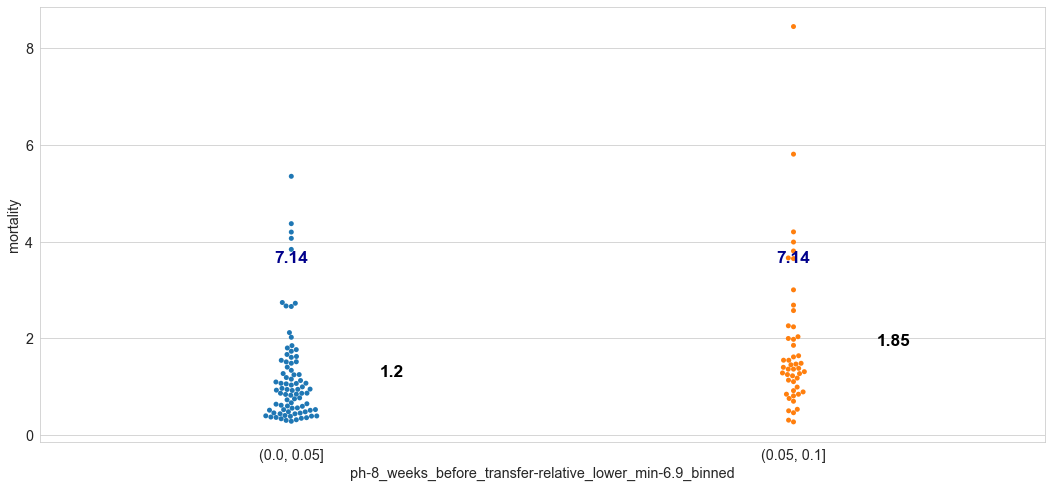

In [387]:
sns.set_style("whitegrid")

step = 0.05

factor = 'ph-8_weeks_before_transfer-relative_lower_min-6.9'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.95)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'mortality'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
# plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

array([[ 1.19751316,  1.8529282 ],
       [ 7.13757942,  7.14246764],
       [83.        , 48.        ]])

<Figure size 1080x360 with 0 Axes>

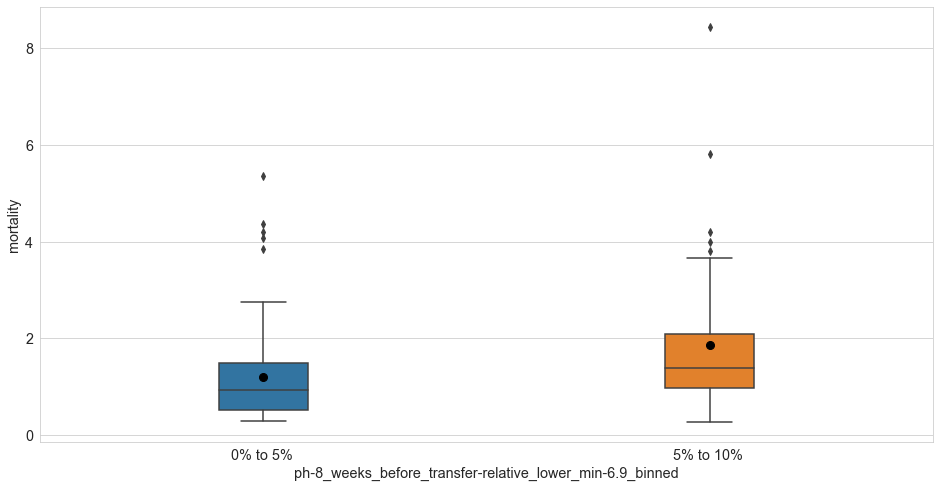

In [399]:
plot_slide_chart('ph-8_weeks_before_transfer-relative_lower_min-6.9','P4',.01,.95,.05,'perc')

### Finding 5: TGC vs 8_weeks_before_transfer_max 

<Figure size 1080x360 with 0 Axes>

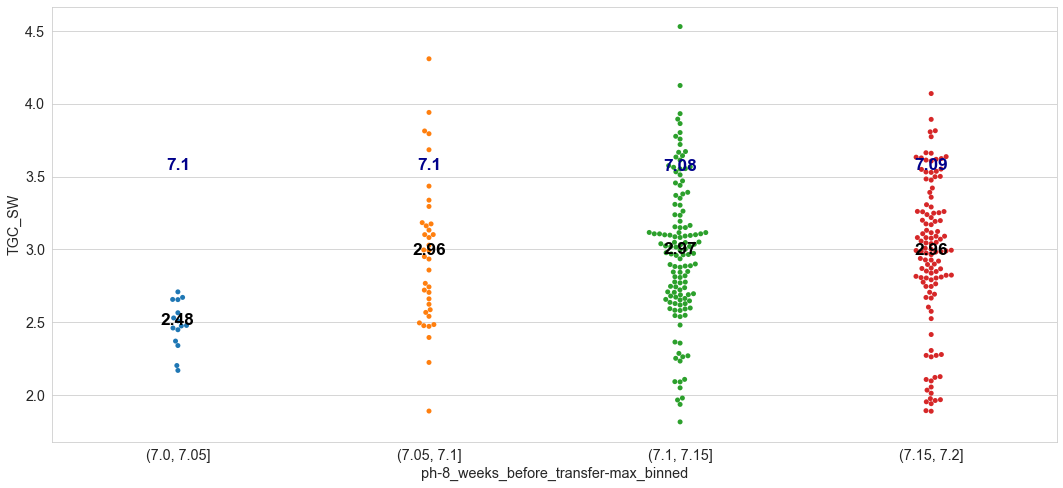

In [46]:
sns.set_style("whitegrid")

step = 0.05

factor = 'ph-8_weeks_before_transfer-max'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.8)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'TGC_SW'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
# plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

<Figure size 1080x360 with 0 Axes>

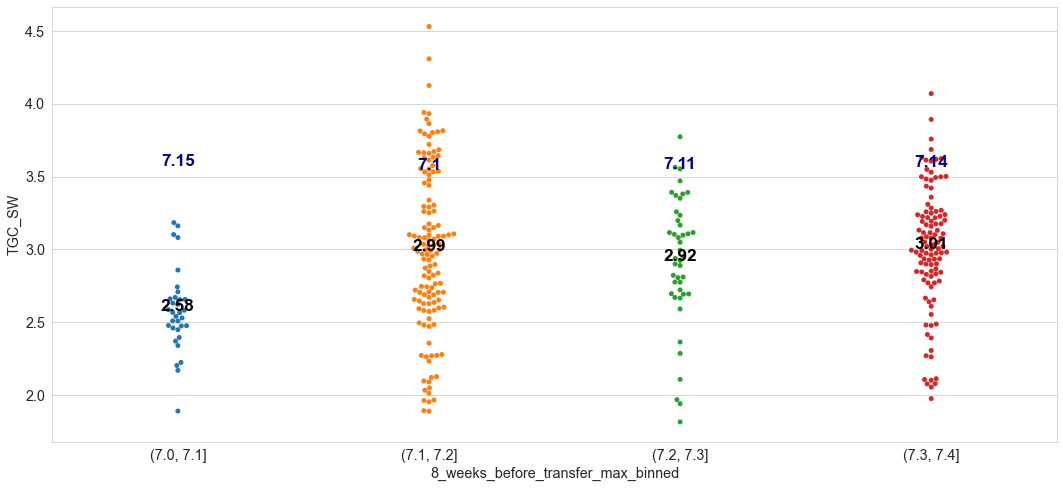

<Figure size 1080x360 with 0 Axes>

In [93]:
sns.set_style("whitegrid")

step = 0.1

factor = '8_weeks_before_transfer_max'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.8)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'TGC_SW'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

### Finding 6: TGC vs ph_transfer_vaccination_std

<Figure size 1080x360 with 0 Axes>

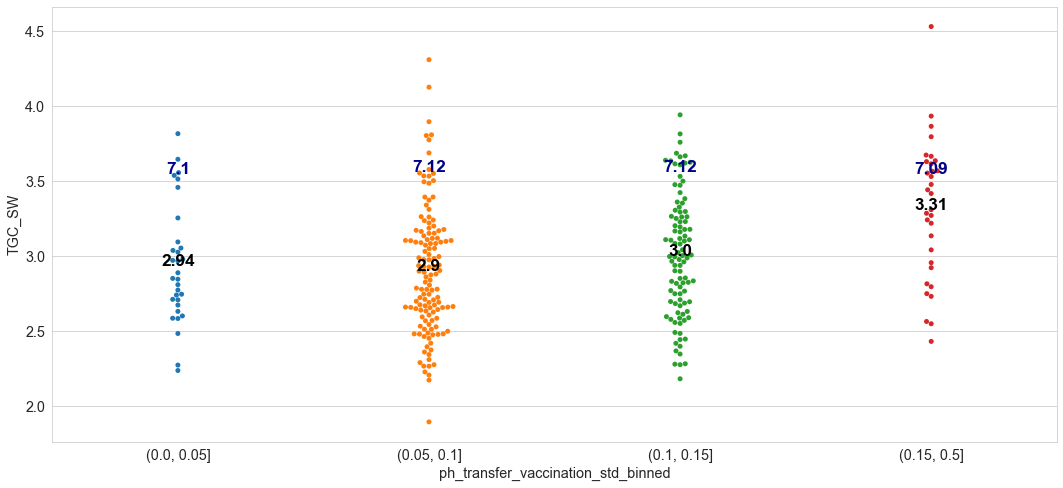

<Figure size 1080x360 with 0 Axes>

In [99]:
sns.set_style("whitegrid")

step = 0.15

factor = 'ph_transfer_vaccination_std'
# bins_tuple=tuple(i*step for i in range(
#     int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.8)/step)+1)
# )
bins_tuple = (0.0, 0.05, 0.1, 0.15, 0.5)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'TGC_SW'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

In [52]:
factors_df.columns

Index(['locus_id', 'fish_group_id', 'transfer_year',
       'ph-2_weeks_before_transfer-cv',
       'ph-2_weeks_before_transfer-cv-from_mean',
       'ph-2_weeks_before_transfer-cv-from_mean-abs',
       'ph-2_weeks_before_transfer-max',
       'ph-2_weeks_before_transfer-max-from_mean',
       'ph-2_weeks_before_transfer-max-from_mean-abs',
       'ph-2_weeks_before_transfer-mean',
       ...
       'ph-transfer_vaccination-std-from_mean',
       'ph-transfer_vaccination-std-from_mean-abs',
       'ph-vaccination_transfer-btw_min_max-6.9-7.3',
       'ph-vaccination_transfer-higher_max-7.3',
       'ph-vaccination_transfer-lower_min-6.9',
       'ph-vaccination_transfer-relative_higher_max-7.3',
       'ph-vaccination_transfer-relative_lower_min-6.9',
       'ph-vaccination_transfer-relative_out_min_max-6.9-7.3', 'mortality',
       'TGC_SW'],
      dtype='object', length=119)

In [53]:
significant_factors = [
    'ph-8_weeks_before_transfer-std',
    'ph-8_weeks_before_transfer-max',
    'ph-8_weeks_before_transfer-relative_higher_max-7.3',
    'ph-8_weeks_before_transfer-relative_lower_min-6.9',
    'ph-transfer_vaccination-std'
]

In [54]:
key_factors = ['locus_id', 'fish_group_id', 'transfer_year']
targets = ['mortality', 'TGC_SW']

In [55]:
sig_factors_df = factors_df[key_factors + significant_factors + targets]

In [58]:
sig_factors_df.to_csv('./data/significant_factors_ph.csv', index=False)

## Various swarmplots (TGC)

<Figure size 1080x360 with 0 Axes>

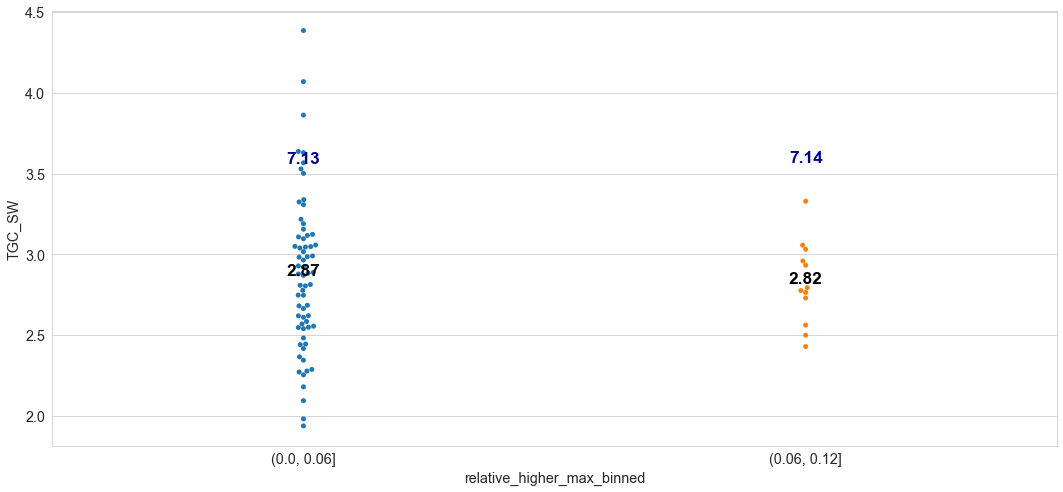

<Figure size 1080x360 with 0 Axes>

In [59]:
sns.set_style("whitegrid")

step=0.06

factor = 'relative_higher_max'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.99)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'TGC_SW'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

<Figure size 1080x360 with 0 Axes>

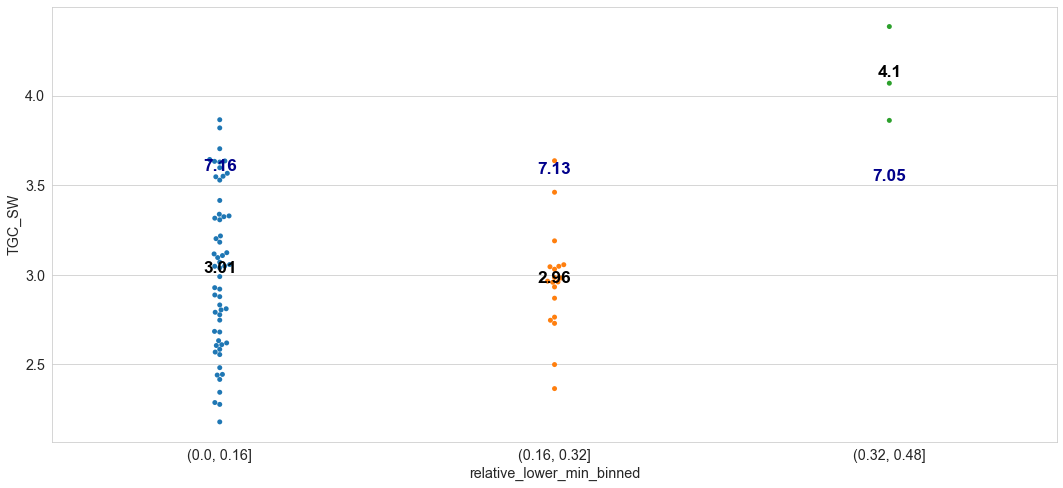

<Figure size 1080x360 with 0 Axes>

In [60]:
sns.set_style("whitegrid")

step=0.16

factor = 'relative_lower_min'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.99)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'TGC_SW'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

<Figure size 1080x360 with 0 Axes>

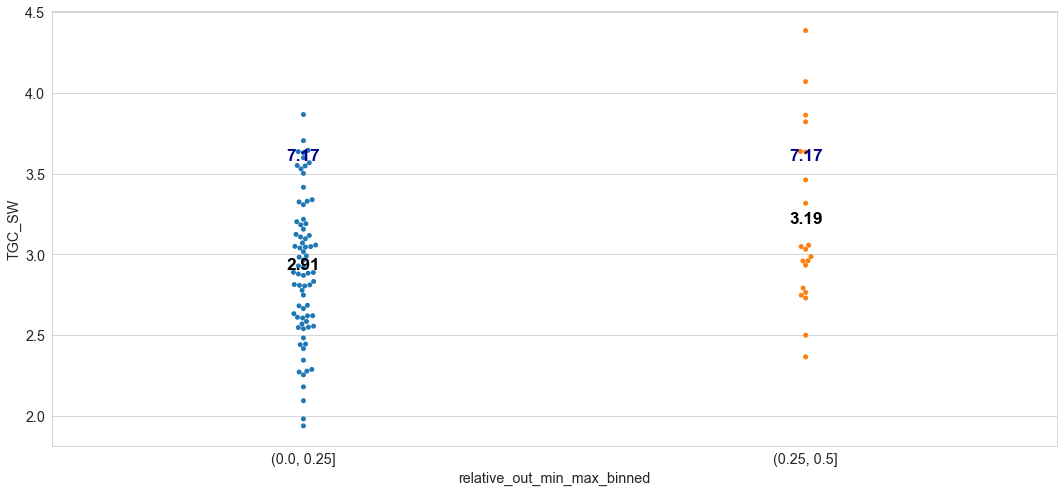

<Figure size 1080x360 with 0 Axes>

In [58]:
sns.set_style("whitegrid")

step=0.25


factor = 'relative_out_min_max'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.99)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'TGC_SW'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

<Figure size 1080x360 with 0 Axes>

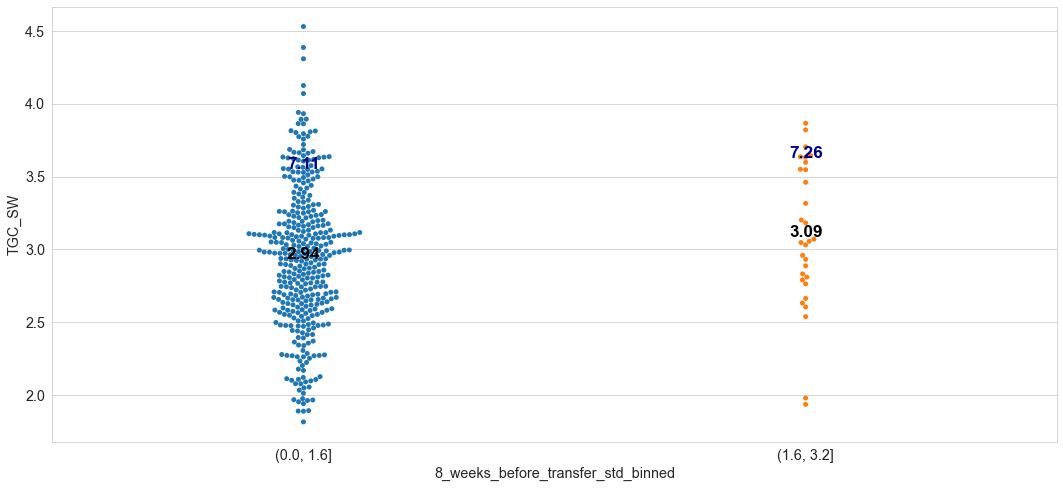

<Figure size 1080x360 with 0 Axes>

In [68]:
sns.set_style("whitegrid")

step=1.6

factor = '8_weeks_before_transfer_std'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.99)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'TGC_SW'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

<Figure size 1080x360 with 0 Axes>

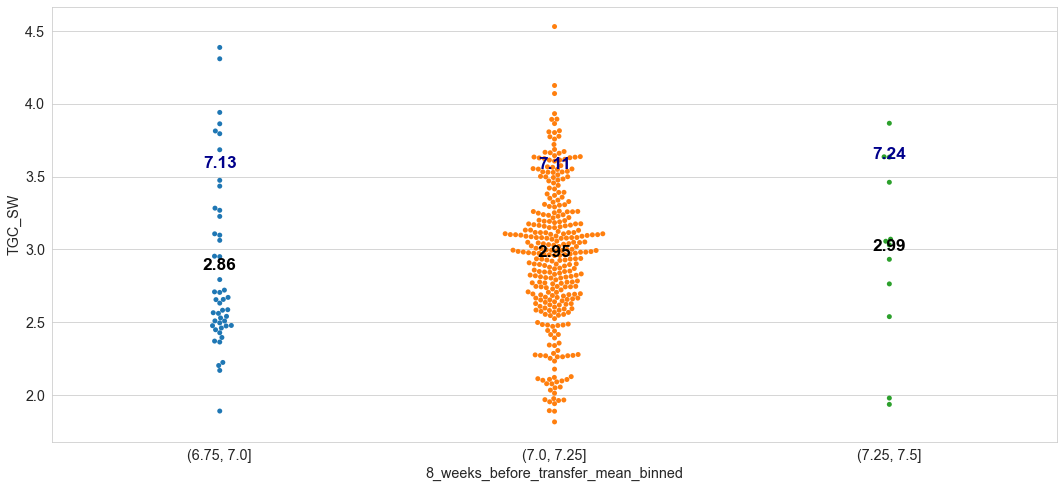

<Figure size 1080x360 with 0 Axes>

In [69]:
sns.set_style("whitegrid")

step=0.25

factor = '8_weeks_before_transfer_mean'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.99)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'TGC_SW'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

<Figure size 1080x360 with 0 Axes>

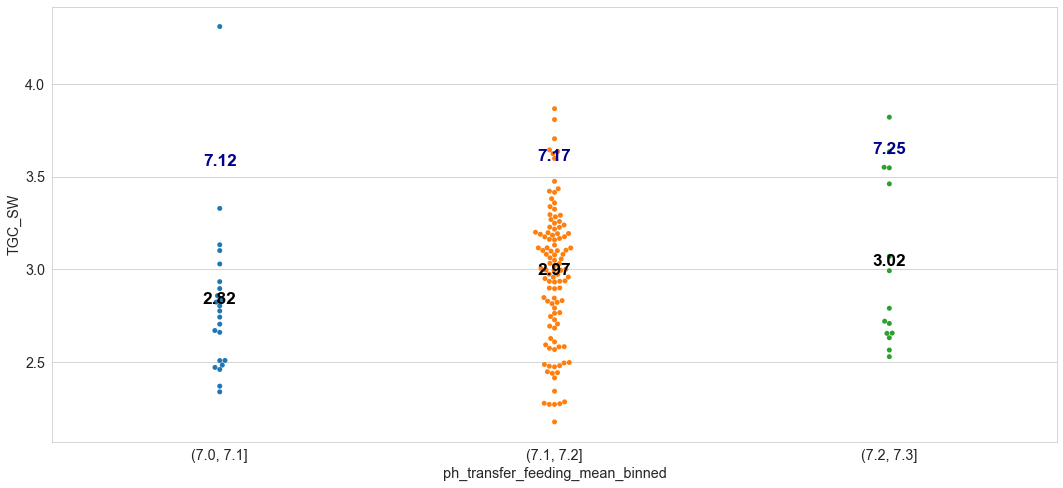

<Figure size 1080x360 with 0 Axes>

In [70]:
sns.set_style("whitegrid")

step=0.1

factor = 'ph_transfer_feeding_mean'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.99)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'TGC_SW'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')